# Simulation and Visualization of the "100 Prisoners Problem"

In this notebook, we simulate and visualize the famous **100 Prisoners Problem**:
- **Strategies simulated**:
   1. Random-Draw strategy
   2. Cycle-Following strategy

 - **Outputs produced**:
   1. Bar chart comparing survival probabilities of the two strategies
   2. Histogram of maximum cycle lengths in random permutations
   3. NetworkX graph showing cycle structures in example permutations

# **Notes**:
- Designed to run inline in Jupyter.
- Uses `matplotlib` for plotting and `networkx` for cycle visualization.
- By default, runs ~20,000 trials (adjustable).

In [86]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt

# Parameters and Setup
- `N_PRISONERS`: number of prisoners (and drawers).
- `MAX_OPENS`: maximum number of drawers each prisoner can open (50).
- `TRIALS`: number of simulations to run (20,000 by default).

Random seeds are fixed for reproducibility.


In [87]:
N_PRISONERS = 100
MAX_OPENS = N_PRISONERS // 2  # 50
TRIALS = 20000

random.seed(0)
np.random.seed(0)

# Core Functions

We define helper functions to generate random permutations, compute cycle lengths, and simulate both strategies.

In [88]:
def random_permutation(n: int) -> list:
    """
    Generate a random permutation of numbers 0..n-1.
    
    Parameters
    ----------
    n : int
        Size of the permutation (number of drawers).
    
    Returns
    -------
    list
        A randomly shuffled list of numbers 0..n-1 representing drawer contents.
    """
    arr = list(range(n))
    random.shuffle(arr)
    
    return arr

In [89]:
def max_cycle_length(perm: list) -> int:
    """
    Compute the maximum cycle length in a given permutation.
    
    Parameters
    ----------
    perm : list
        A permutation list where perm[i] is the number in drawer i.
    
    Returns
    -------
    int
        The length of the longest cycle in the permutation.
    """
    n = len(perm)
    visited = [False] * n
    max_len = 0

    for i in range(n):
        if not visited[i]:
            cur = i
            length = 0
            # Follow the cycle until it loops back
            while not visited[cur]:
                visited[cur] = True
                cur = perm[cur]
                length += 1
            max_len = max(max_len, length)
    
    return max_len

In [90]:
def cycle_following_success(perm: list, max_opens: int = MAX_OPENS) -> bool:
    """
    Check success of the cycle-following strategy for all prisoners.
    
    Success occurs if all cycles in the permutation have length ≤ max_opens.
    
    Parameters
    ----------
    perm : list
        The permutation of drawer contents.
    max_opens : int
        Maximum number of drawers each prisoner can open.
    
    Returns
    -------
    bool
        True if all prisoners succeed, False otherwise.
    """
    return max_cycle_length(perm) <= max_opens

In [91]:
def random_draw_success(perm: list, max_opens: int = MAX_OPENS) -> bool:
    """
    Check success of the random-draw strategy.
    
    Each prisoner opens `max_opens` random drawers. The group succeeds if all prisoners
    find their number this way.
    
    Parameters
    ----------
    perm : list
        The permutation of drawer contents.
    max_opens : int
        Maximum number of drawers each prisoner can open.
    
    Returns
    -------
    bool
        True if all prisoners succeed, False otherwise.
    """
    n = len(perm)
    for prisoner in range(n):
        # Each prisoner chooses random drawers independently
        choices = random.sample(range(n), max_opens)
        if not any(perm[idx] == prisoner for idx in choices):
            return False
    
    return True

# Simulation Loop
We run `TRIALS` permutations and record:
 - Maximum cycle lengths
 - Whether each strategy succeeded.
 - Aggregate statistics for comparison

In [92]:
cycle_success_count = 0
random_success_count = 0
max_cycle_lengths = []

for _ in range(TRIALS):
    perm = random_permutation(N_PRISONERS)
    mcl = max_cycle_length(perm)
    max_cycle_lengths.append(mcl)
    
    if mcl <= MAX_OPENS:
        cycle_success_count += 1
    if random_draw_success(perm, MAX_OPENS):
        random_success_count += 1

# Results Table
Compute survival probabilities and standard errors for both strategies.

In [93]:
p_cycle = cycle_success_count / TRIALS
se_cycle = sqrt(p_cycle * (1 - p_cycle) / TRIALS)
p_random = random_success_count / TRIALS
se_random = sqrt(p_random * (1 - p_random) / TRIALS)

results = pd.DataFrame({
    "strategy": ["Cycle-Following", "Random-Draw"],
    "success_count": [cycle_success_count, random_success_count],
    "trials": [TRIALS, TRIALS],
    "probability": [p_cycle, p_random],
    "std_error": [se_cycle, se_random]
})

In [94]:
results

,strategy,success_count,trials,probability,std_error
0,Cycle-Following,6126,20000,0.3063,0.003259
1,Random-Draw,0,20000,0.0000,0.000000


# Plot 1: Survival Probabilities
- Bar chart comparing estimated probabilities of survival under each strategy.


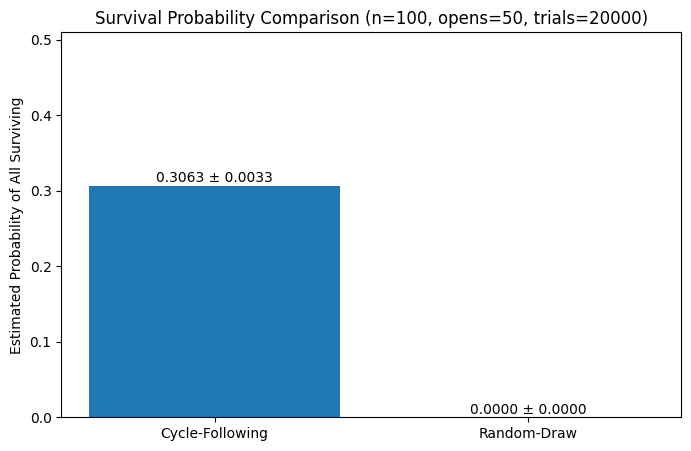

In [95]:
plt.figure(figsize=(8,5))
plt.bar(results["strategy"], results["probability"])
plt.ylabel("Estimated Probability of All Surviving")
plt.title(f"Survival Probability Comparison (n={N_PRISONERS}, opens={MAX_OPENS}, trials={TRIALS})")

# Annotate bars with probability ± std error
for i, v in enumerate(results["probability"]):
    plt.text(i, v + 0.005, f"{v:.4f} ± {results['std_error'][i]:.4f}", ha='center')

plt.ylim(0, max(results["probability"]) * 1.6 + 0.02)
plt.show()

# Plot 2: Distribution of Maximum Cycle Lengths
- The histogram shows how maximum cycle lengths are distributed in random permutations.
- The vertical line marks the 50-drawer threshold for success.


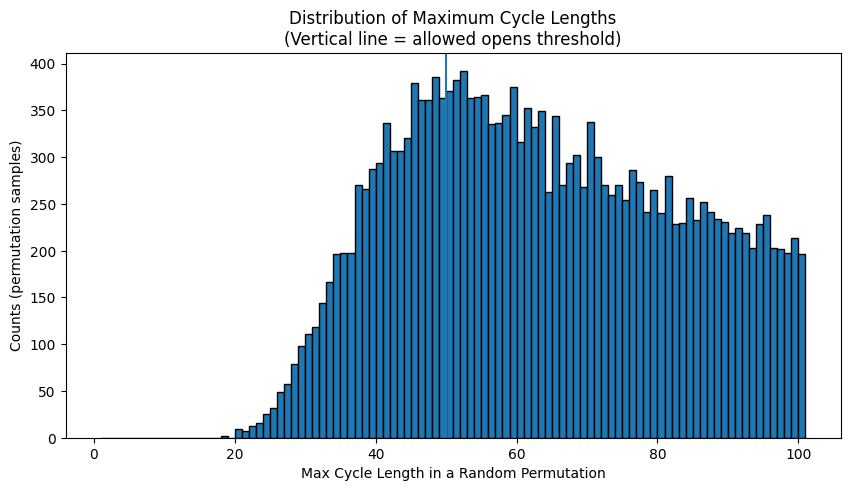

In [96]:
plt.figure(figsize=(10,5))
plt.hist(max_cycle_lengths, bins=range(1, max(max_cycle_lengths)+2), edgecolor='black')
plt.axvline(MAX_OPENS, linestyle='solid')
plt.xlabel("Max Cycle Length in a Random Permutation")
plt.ylabel("Counts (permutation samples)")
plt.title("Distribution of Maximum Cycle Lengths\n(Vertical line = allowed opens threshold)")

plt.show()

# Plot 3: Cycle Graph Visualization
- Using NetworkX, we visualize two example permutations:
- **Success case**: All cycles ≤ 50
- **Failure case**: Contains at least one cycle > 50

In [97]:
# Find example permutations for visualization
example_perm_success = None
example_perm_failure = None

while example_perm_success is None or example_perm_failure is None:
    perm = random_permutation(N_PRISONERS)
    if cycle_following_success(perm) and example_perm_success is None:
        example_perm_success = perm.copy()
    if not cycle_following_success(perm) and example_perm_failure is None:
        example_perm_failure = perm.copy()

In [98]:
def build_cycle_graph(perm: list) -> nx.DiGraph:
    """
    Build a directed graph from a permutation.
    
    Nodes represent drawers (0..n-1).
    Each directed edge i -> perm[i] represents the pointer to the next drawer.
    """
    G = nx.DiGraph()
    n = len(perm)
    for i in range(n):
        G.add_edge(i, perm[i])
    
    return G

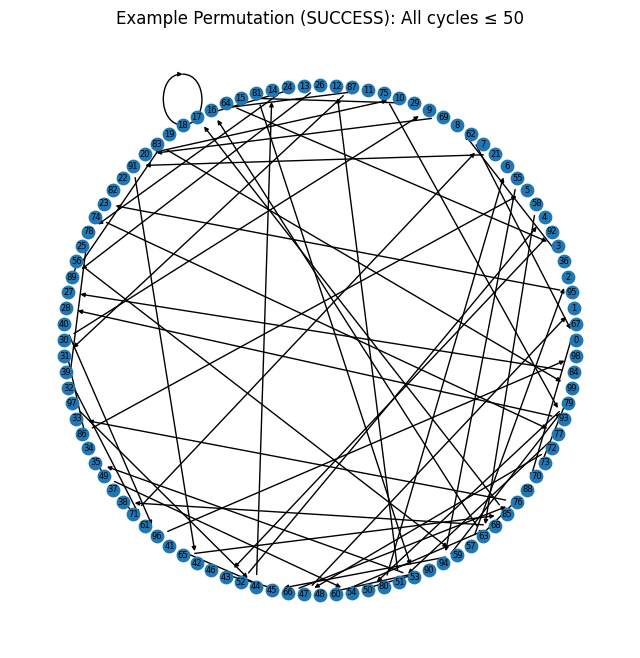

In [99]:
# Success graph
G_succ = build_cycle_graph(example_perm_success)

plt.figure(figsize=(8,8))
pos = nx.circular_layout(G_succ)
nx.draw_networkx_nodes(G_succ, pos, node_size=80)
nx.draw_networkx_labels(G_succ, pos, font_size=6)
nx.draw_networkx_edges(G_succ, pos, arrowsize=6)

plt.title("Example Permutation (SUCCESS): All cycles ≤ 50")
plt.axis('off')

plt.show()

In [100]:
def get_cycles(perm: list) -> list:
    """
    Decompose a permutation into disjoint cycles.
    Returns a list of cycles, where each cycle is a list of nodes.
    """
    n = len(perm)
    visited = [False] * n
    cycles = []

    for i in range(n):
        if not visited[i]:
            cycle = []
            current = i
            while not visited[current]:
                visited[current] = True
                cycle.append(current)
                current = perm[current]
            cycles.append(cycle)
    
    return cycles

def plot_cycles(perm: list, title: str):
    """
    Plot cycles of a permutation using NetworkX.
    Each cycle is drawn separately as a circular subgraph.
    """
    cycles = get_cycles(perm)
    
    # Create figure with one subplot per cycle
    fig, axes = plt.subplots(1, len(cycles), figsize=(3*len(cycles), 3))
    if len(cycles) == 1:
        axes = [axes]  # Make iterable if single axis

    for ax, cycle in zip(axes, cycles):
        G = nx.DiGraph()
        for i in range(len(cycle)):
            G.add_edge(cycle[i], cycle[(i+1) % len(cycle)])
        pos = nx.circular_layout(G)
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=200)
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
        nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=10)
        ax.set_title(f"Cycle length {len(cycle)}")
        ax.axis('off')
    
    fig.suptitle(title, fontsize=14)
    
    plt.show()

In [101]:
def plot_cycles_single(perm: list, title: str):
    """
    Plot all cycles in one graph using NetworkX (disjoint circular components).
    """
    cycles = get_cycles(perm)
    G = nx.DiGraph()

    # Add edges for each cycle
    for cycle in cycles:
        for i in range(len(cycle)):
            G.add_edge(cycle[i], cycle[(i+1) % len(cycle)])

    # Layout: arrange cycles as separate groups
    pos = {}
    radius = 5
    angle_step = 2 * np.pi / len(cycles)

    for idx, cycle in enumerate(cycles):
        angle = idx * angle_step
        cx, cy = radius * np.cos(angle), radius * np.sin(angle)
        cycle_pos = nx.circular_layout(G.subgraph(cycle), scale=1.0, center=(cx, cy))
        pos.update(cycle_pos)

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, node_size=200)
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=10)
    plt.title(title, fontsize=14)
    plt.axis('off')
    
    plt.show()

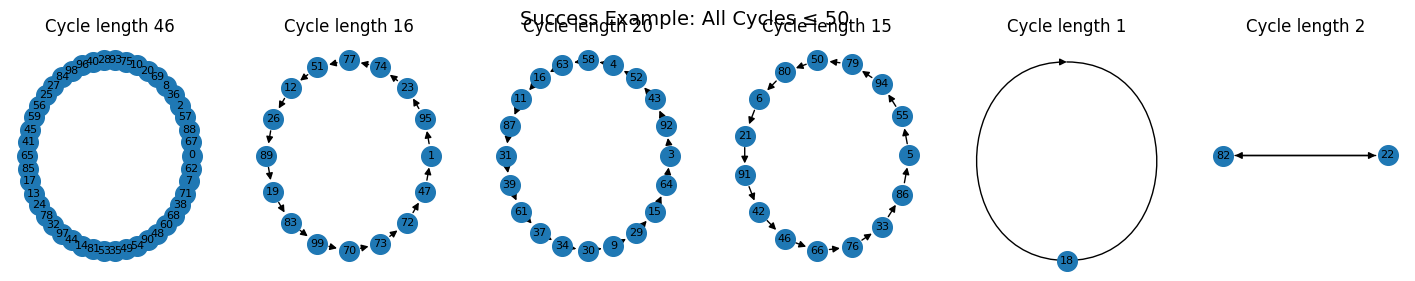

In [102]:
# Plot success permutation cycles
plot_cycles(example_perm_success, "Success Example: All Cycles ≤ 50")

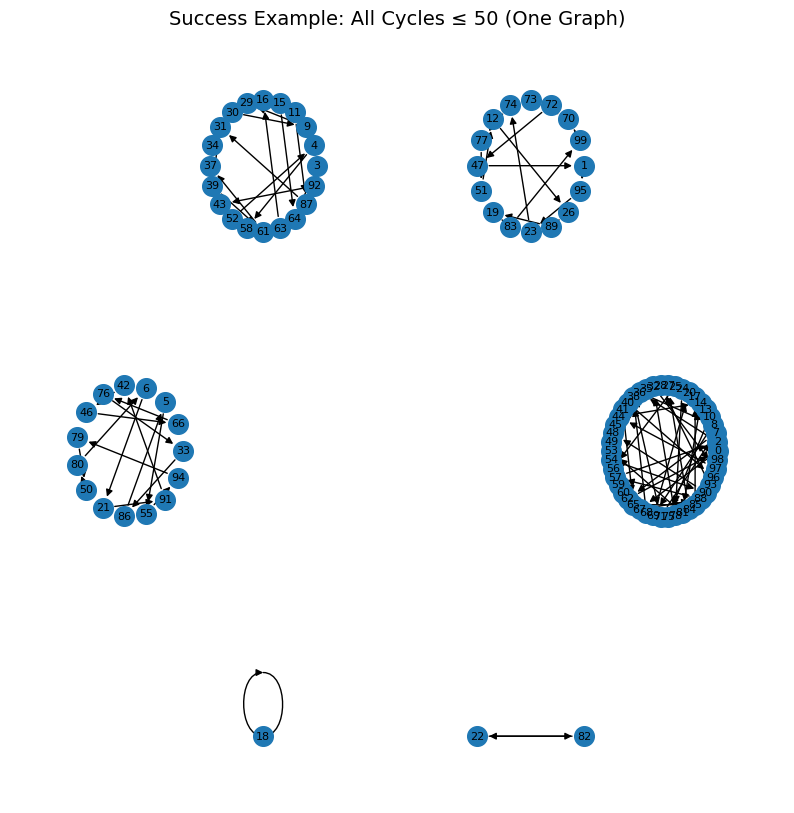

In [103]:
plot_cycles_single(example_perm_success, "Success Example: All Cycles ≤ 50 (One Graph)")

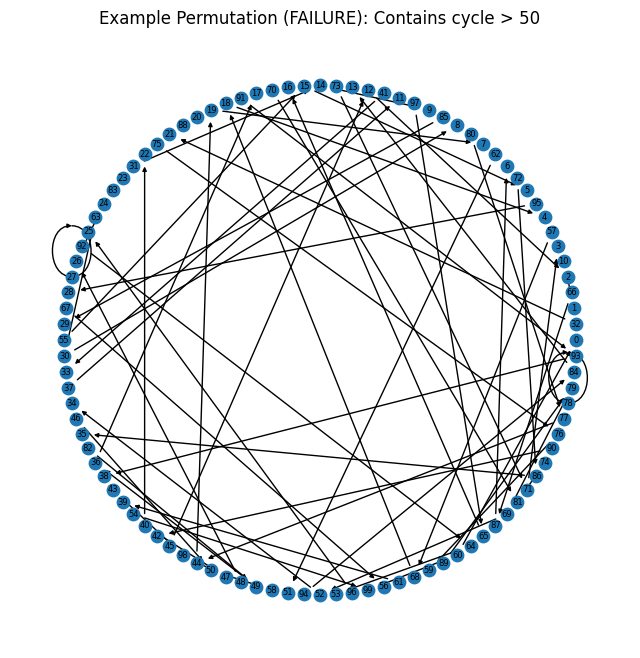

In [104]:
# Failure graph
G_fail = build_cycle_graph(example_perm_failure)

plt.figure(figsize=(8,8))
pos = nx.circular_layout(G_fail)
nx.draw_networkx_nodes(G_fail, pos, node_size=80)
nx.draw_networkx_labels(G_fail, pos, font_size=6)
nx.draw_networkx_edges(G_fail, pos, arrowsize=6)

plt.title("Example Permutation (FAILURE): Contains cycle > 50")
plt.axis('off')

plt.show()

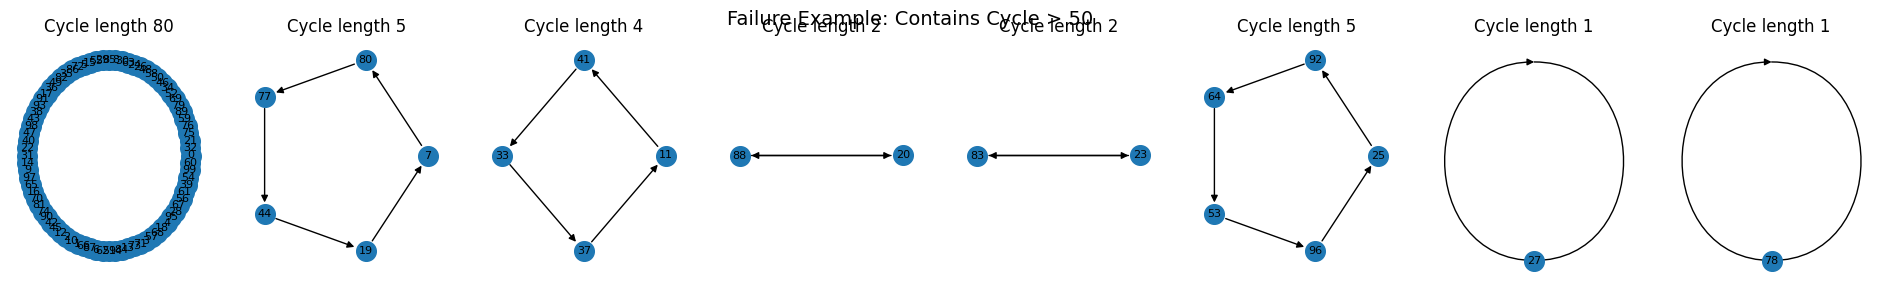

In [105]:
# Plot failure permutation cycles
plot_cycles(example_perm_failure, "Failure Example: Contains Cycle > 50")

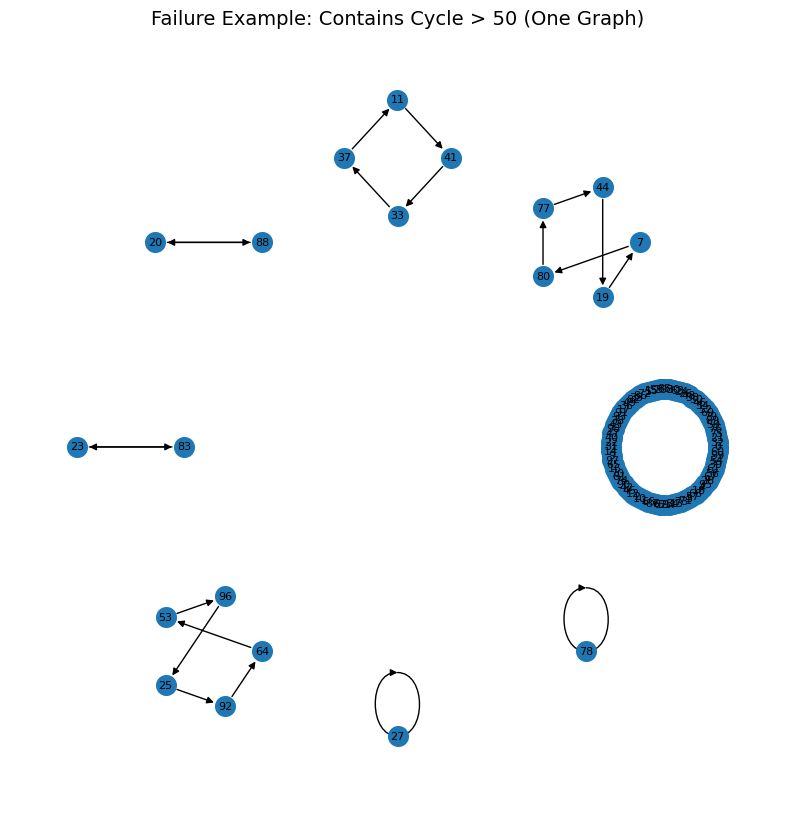

In [106]:
plot_cycles_single(example_perm_failure, "Failure Example: Contains Cycle > 50 (One Graph)")

# Interactive Plots 

In [107]:
import plotly.graph_objects as go

def plot_cycles_plotly(perm, title="Permutation Cycles"):
    """
    Visualize the disjoint cycles of a permutation as an interactive directed graph 
    using NetworkX for graph structure and Plotly for rendering.

    This function decomposes a permutation into its disjoint cycles, constructs a
    directed graph where each node represents a drawer (or prisoner index) and each 
    directed edge i → perm[i] represents the "pointer" to the next drawer in the cycle.
    The graph is displayed interactively with Plotly, allowing zooming, panning, and 
    hover tooltips for exploration.

    Parameters
    ----------
    perm : list of int
        A permutation of integers 0..n-1, where perm[i] is the number contained in 
        drawer i (or equivalently, the mapping i → perm[i]).
    title : str, optional (default="Permutation Cycles")
        The title of the Plotly figure.

    Visualization Details
    ---------------------
    - Nodes are displayed as blue circular markers labeled with their indices.
    - Directed edges show cycle transitions, connecting each node to its mapped value.
    - Hovering over nodes displays tooltips with their numeric label.
    - Layout is computed using NetworkX's `spring_layout` for visually separated cycles.

    Notes
    -----
    - Unlike a static NetworkX + Matplotlib plot, this visualization is fully interactive.
      You can zoom, pan, and hover directly in Jupyter Notebook or JupyterLab.
    - The resulting figure can also be exported as an interactive HTML file with 
      `fig.write_html("filename.html")` for sharing or embedding.

    Example
    -------
    >>> perm = [2, 0, 1, 4, 3]  # example permutation
    >>> plot_cycles_plotly(perm, title="Example Permutation Cycles")

    This will open an interactive Plotly visualization of the two disjoint cycles:
    (0 → 2 → 1 → 0) and (3 → 4 → 3).
    """
    
    cycles = get_cycles(perm)
    G = nx.DiGraph()
    for cycle in cycles:
        for i in range(len(cycle)):
            G.add_edge(cycle[i], cycle[(i+1) % len(cycle)])

    pos = nx.spring_layout(G, seed=42)

    # Edges
    edge_x, edge_y = [], []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color="#888"),
        hoverinfo="none",
        mode="lines"
    )

    # Nodes
    node_x, node_y, node_text = [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"Node {node}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        text=[str(n) for n in G.nodes()],
        textposition="top center",
        hovertext=node_text,
        marker=dict(size=10, color="skyblue", line_width=2)
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title,
                        title_x=0.5,
                        showlegend=False,
                        hovermode="closest"
                    ))
    fig.show()

In [108]:
plot_cycles_plotly(example_perm_success, "Success Example (Interactive with Plotly)")

In [109]:
plot_cycles_plotly(example_perm_failure, "Failure Example (Interactive with Plotly)")

# Numeric Summary
- We print simulation results and compare them to theoretical expectations.


In [110]:
print("=== Numeric Summary ===")
print(results.to_string(index=False))

print("\nAnalytical reference: for N=100 and opens=50, the theoretical probability of success using the cycle-following strategy is approximately 0.3118 (≈31.18%).\n")
print(f"Simulated cycle-following success proportion = {p_cycle:.6f} ± {se_cycle:.6f} (n={TRIALS})")
print()
print(f"Simulated random-draw success proportion =    {p_random:.6e} ± {se_random:.6e} (n={TRIALS})")

=== Numeric Summary ===
       strategy  success_count  trials  probability  std_error
Cycle-Following           6126   20000       0.3063   0.003259
    Random-Draw              0   20000       0.0000   0.000000

Analytical reference: for N=100 and opens=50, the theoretical probability of success using the cycle-following strategy is approximately 0.3118 (≈31.18%).

Simulated cycle-following success proportion = 0.306300 ± 0.003259 (n=20000)

Simulated random-draw success proportion =    0.000000e+00 ± 0.000000e+00 (n=20000)
